<a href="https://colab.research.google.com/github/100514802/ResiduosClasificador/blob/master/ResNet50/ResNet50_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ejecutar esta celda ÚNICAMENTE si se está trabajando en GOOGLE COLAB

if 'google.colab' in str(get_ipython()):
    import os
    ! git clone https://github.com/100514802/ResiduosClasificador
    ! pip install torchmetrics
    import os
    # Carga tu conjunto de datos (ajusta según tu estructura de datos)
    data_train_path = os.path.join('/content/ResiduosClasificador/Dataset_train')
    data_test_path = os.path.join('/content/ResiduosClasificador/Dataset_test')
    print('Instalado en Colab')
else:
    # Carga tu conjunto de datos (ajusta según tu estructura de datos)
    import os
    data_train_path = os.path.join('..','Dataset_train')
    data_test_path = os.path.join('..','Dataset_test')
    print('Ejecutando en local')

Ejecutando en local


In [2]:
import os
import matplotlib.pyplot as plt
import random
import copy
import torch
import torchvision
import torchmetrics
import json
from torch import nn, optim

In [3]:
# Define la transformación para las imágenes (ajusta según tus necesidades)
transf = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
])

# Learning rate
lr=0.0001

# Número de epochs de entrenamiento
num_epochs = 5

# Batch size
batch_size = 64

dataset_train = torchvision.datasets.ImageFolder(root=data_train_path, transform=transf)
dataset_test = torchvision.datasets.ImageFolder(root=data_test_path, transform=transf)

train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(dataset_test, batch_size, shuffle=False, num_workers=2)

labels = dataset_train.classes
print(f'Clases {labels}')
num_classes = len(labels)

# Crear un diccionario que mapee índices a etiquetas
mapeo_etiquetas = {str(i): etiqueta for i, etiqueta in enumerate(labels)}

# Guardar el diccionario en un archivo JSON
with open('etiquetas.json', 'w') as archivo_json:
    json.dump(mapeo_etiquetas, archivo_json)

Clases ['cardboard', 'glass', 'metal', 'paper', 'plastic']


In [4]:
# Carga el modelo preentrenado ResNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.resnet50(pretrained=True).to(device)

c:\Users\quiqu\miniconda3\envs\pic\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\quiqu\miniconda3\envs\pic\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Ajusta la última capa para tu tarea específica
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)  # num_classes es el número de clases del conjunto de datos

# Define la función de pérdida, el optimizador y la métrica de precision
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr)
metrics_fn = torchmetrics.classification.MulticlassAccuracy(
    num_classes, average='micro').to(device)

# Movemos el modelo a la GPU (si está disponible)
model.to(device)

# Creamos listas para almacenar los histórico de pérdidas y precisión, tanto
# de entrenamiento como de test.
best_acc = 0
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

# Entrenamiento
for epoch in range(num_epochs):
    device = next(model.parameters()).device
    model.train()
    
    for inputs, labels in train_dataloader:
        inputs,labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    
    model.eval()
    train_epoch_loss = 0
    train_correct = 0
    train_total = 0
    with torch.no_grad():
        loss = 0
        for inputs, labels in train_dataloader:
            # Calcular la precisión
            inputs,labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum()
            train_epoch_loss += loss
    
    test_epoch_loss = 0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        loss = 0
        for inputs, labels in test_dataloader:
            # Calcular la precisión
            inputs,labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum()
            test_epoch_loss += loss

    # Calcular la pérdida y precisión promedio para el epoch
    avg_loss_train = train_epoch_loss / len(train_dataloader)
    avg_loss_test = test_epoch_loss / len(test_dataloader)
    
    accuracy_train = train_correct / train_total
    accuracy_test = test_correct / test_total
    
    if best_acc <= accuracy_test:
        best_acc = accuracy_test
        best_model = copy.deepcopy(model)
    
    train_loss_history.append(avg_loss_train)
    train_acc_history.append(accuracy_train)
    test_loss_history.append(avg_loss_test)
    test_acc_history.append(accuracy_test)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss_train:.4f}, Train Accuracy: {accuracy_train * 100:.2f}%')
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {avg_loss_test:.4f}, Test Accuracy: {accuracy_test * 100:.2f}%')
    
#Vamos a guardar el modelo entrenado en la carpeta models
models_path = os.path.join('..','PIC', 'models')
os.makedirs(models_path, exist_ok=True)
torch.save(model, os.path.join(models_path, 'ResNet50.pt'))

Epoch [1/5], Train Loss: 0.1305, Train Accuracy: 96.76%
Epoch [1/5], Test Loss: 0.3952, Test Accuracy: 88.50%
Epoch [2/5], Train Loss: 0.0357, Train Accuracy: 99.18%
Epoch [2/5], Test Loss: 0.3188, Test Accuracy: 89.50%
Epoch [3/5], Train Loss: 0.0216, Train Accuracy: 99.32%
Epoch [3/5], Test Loss: 0.5372, Test Accuracy: 84.50%
Epoch [4/5], Train Loss: 0.0203, Train Accuracy: 99.41%
Epoch [4/5], Test Loss: 0.5454, Test Accuracy: 89.50%
Epoch [5/5], Train Loss: 0.0565, Train Accuracy: 98.36%
Epoch [5/5], Test Loss: 0.4934, Test Accuracy: 86.00%


In [6]:
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
with torch.no_grad():
    for inputs, labels in train_dataloader:
        inputs,labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(num_classes):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(num_classes):
    print('Accuracy of %s : %2d %%' % (
        dataset_train.classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of cardboard : 100 %
Accuracy of glass : 100 %
Accuracy of metal : 93 %
Accuracy of paper : 96 %
Accuracy of plastic : 96 %


In [7]:
print(train_loss_history)
print(test_loss_history)


[tensor(0.1305), tensor(0.0357), tensor(0.0216), tensor(0.0203), tensor(0.0565)]
[tensor(0.3952), tensor(0.3188), tensor(0.5372), tensor(0.5454), tensor(0.4934)]


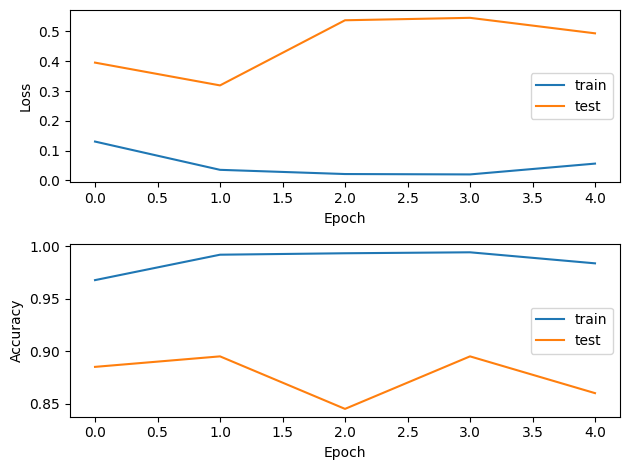

<Figure size 640x480 with 0 Axes>

In [8]:
# Gráfica de la evolución de la pérdida y la precisión
plt.subplot(2, 1, 1)
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(train_acc_history, label='train')
plt.plot(test_acc_history, label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('GraphsResNet50.png')


Predicción: cardboard
Real: cardboard


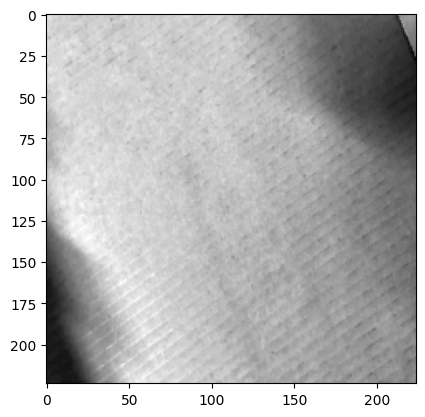

In [11]:
# Visualización de resultados
x, y = next(iter(test_dataloader))
y_pred = model(x.to(device))

# Probamos con una imagen aleatoria del dataset de test
i = random.randint(0, len(x)-1)
plt.imshow(x[i, 0], cmap='gray');
print('Predicción: {}'.format(dataset_train.classes[y_pred.argmax(dim=1)[i]]))
print('Real: {}'.format(dataset_train.classes[y[i]]))

In [12]:
models_path = os.path.join('..','PIC', 'models')
model = torch.load(os.path.join(models_path, 'ResNet50.pt')).to(device)

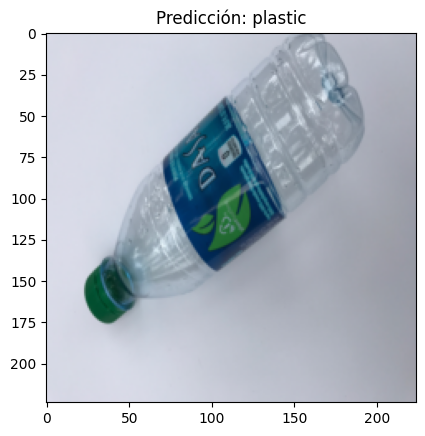

In [15]:
from PIL import Image
# Ruta de la imagen que deseas predecir
image_path = os.path.join('..','Dataset_class','plastic14.jpg')
image = Image.open(image_path)

# Aplicar la transformación
transformed_image = transf(image)

transformed_image = transformed_image.unsqueeze(0)  # Añadir dimensión de batch
transformed_image = transformed_image.to(device)  # Enviar al dispositivo

y_pred = model(transformed_image.to(device))


# Mostrar la imagen
plt.imshow(transformed_image.squeeze().permute(1, 2, 0))
plt.title('Predicción: {}'.format(dataset_train.classes[y_pred.argmax(dim=1)]))
plt.show()